# ProDev - ML Workshop

## Descripción del Dataset

El Dataset fue tomado de la base de datos de la Universidad de Wisconsin [Diagnostic Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/ml/datasets/Breast%2BCancer%2BWisconsin%2B%28Diagnostic%29). Este dataset describe las caracteristicas de las celulas de una variedad de tumores (En los bustos). Cada fila del dataset contiene las caraceteristicas de una celula y una etiqueta que lo clasifica como benigno o maligno.

Con estos datos se desea desarrollar un sistema que utilize Machine Learning para determinar si un tumor es maligno o benigno a partir de las caracteristicas de sus celulas. Las técnicas utilizadas para la obtención de estas características van más allá del alcance de este tutorial.

El dataset se compone de las siguientes variables:

1. Id
2. Diagnostico (M = Maligno, B = Benigno)
3. (3-32) Características de cada núcleo de la celula

Se tienen las siguientes características de los núcleos de las celulas:

* Radio
* Textura
* Perimetro
* Área
* Suavidad
* Compactividad
* Concavidad
* Puntos de Concavidad
* Simetria
* Dimensión Fractal

![Image of Cancer](http://farm9.staticflickr.com/8285/7739363138_687b8df92d.jpg)

## Importar Librerias

In [1]:
import numpy as np # Algebra Lineal
import pandas as pd # Procesamiento y Lectura de datos
import itertools

# Generar gráficos en un solo sitio como imágenes estáticas.
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec # subplots
import mpld3 as mpl


#Import models from scikit learn module:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

## Cargar el Dataset

In [3]:
dataset = pd.read_csv("data.csv",header = 0)
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Procesar el Dataset

En primer lugar vamos a remover las columnas que no necesitamos, ya que no aportan información acerca de la variable objetivo. Estas columnas son "id" y "Unnamed: 32".

In [4]:
dataset.drop('id',axis=1,inplace=True)
dataset.drop('Unnamed: 32',axis=1,inplace=True)

# Tamaño del Dataset
print dataset.shape

(569, 31)


Vamos a verificar cuantos valores puede tomar la variable "diagnosis" (Diagnostico), esto lo podemos hacer con el método unique de pandas, el cual retorna un array con los distintos valores que toma la columna del dataset.

In [5]:
dataset.diagnosis.unique()

array(['M', 'B'], dtype=object)

Este resultado indica que solo hay dos posibles diagnósticos, Benigno o Maligno. Por lo tanto vamos a realizar una clasificación binaria. Los algoritmos de clasificación existentes solo manejan datos numericos, por lo cual tenemos que convertir los diagnosticos a un equivalente númerico. Ya que este solo toma dos valores vamos a usar 0 y 1 para identificar los diagnosticos (1 -> Maligno, 0 -> Benigno).

In [6]:
dataset['diagnosis'] = dataset['diagnosis'].map({'M':1,'B':0})
dataset.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Exploración de los Datos

Es realmente fácil visualizar las características estadísticas de las variables cuantitativas del dataset, Pandas permite visulaizarlas fácilmente usando el método "describe".

In [7]:
dataset.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


También podemos generar un gráfico que nos permita ver la distribución del diagnostico de los tumores dentro del dataset.

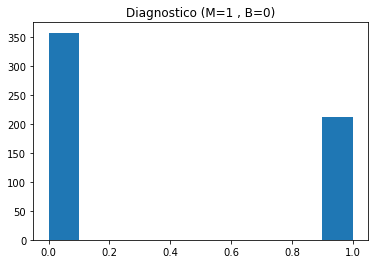

In [14]:
plt.hist(dataset['diagnosis'])
plt.title('Diagnostico (M=1 , B=0)')
plt.show()

### Relación entre Variables y Diagnostico

Para visualizar las relaciones entre variables y diagnostico, debemos separar el dataset en diagnosticos malignos y benignos para poder comparar.

In [8]:
features_mean=list(dataset.columns[1:11])
# split dataframe into two based on diagnosis
datasetM=dataset[dataset['diagnosis'] ==1]
datasetB=dataset[dataset['diagnosis'] ==0]

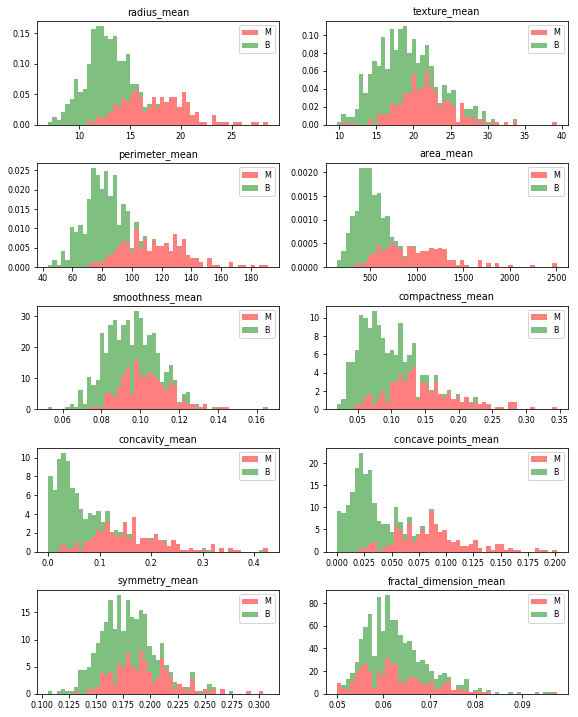

In [16]:
#Generar gráficos
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(dataset[features_mean[idx]]) - min(dataset[features_mean[idx]]))/50
    ax.hist([datasetM[features_mean[idx]],datasetB[features_mean[idx]]], bins=np.arange(min(dataset[features_mean[idx]]), max(dataset[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, normed = True, label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()


Observando los gráficos anteriores podemos concluir lo siguiente:
1. Los valores medios del radio celular, perimetro, área, compactividad, concavidad y puntos de concavidad pueden ser usados para la clasificación del cancer. Los valores más grandes de estas variables tienden a mostrar una correlación con los tumores malignos.

2. Los demás parámetros no muestran una relación clara en los histogramas como para considerarlos como predictores del diagnostico del tumor.

## Crear el Dataset de Pruebas y Entrenamiento

Para crear estos datasets automáticamente podemos usar la utilidad *train_test_split* para separar el dataset en entrenamiento y pruebas. Vamos a usar el 75% del dataset para entrenamiento y el 25% para pruebas.

In [9]:
training, testing = train_test_split(dataset, test_size=0.3, random_state=2)

## Método para entrenar y evaluar los modelos de clasificación

In [10]:
# Función para generar el modelo y evaluar su precisión
# Tomado de: https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
def classification_model(model, data, predictors, outcome):
  #Ajustar el modelo a los datos:
  model.fit(data[predictors],data[outcome])
  
  #Calcular predicciones en el dataset de entrenamiento:
  predictions = model.predict(data[predictors])
  
  #Imprimir la precisión del modelo
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Precisión : %s" % "{0:.3%}".format(accuracy))

  #Validar el modelo usando K-Fold Cross-validation
    
  kf = KFold(n_splits=5, shuffle=True, random_state=6)
  error = []
  for train, test in kf.split(data):
    # Seleccionar los datos de entrenamiento
    train_predictors = data[predictors].iloc[train,:]
    
    # Variable objetivo para el dataset de entrenamiento
    train_target = data[outcome].iloc[train]
    
    # Entrenar el modelo
    model.fit(train_predictors, train_target)
    
    #Guardar el error y el puntaje de validación cruzada
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
    print("Puntaje de Cross-Validation : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Ajustar el modelo para usarlo fuera de la función:
  model.fit(data[predictors],data[outcome])

## Regresión Logistica

La regresión logística resulta útil para los casos en los que se desea predecir la presencia o ausencia de una característica o resultado según los valores de un conjunto de predictores. Usando las variables que identificamos en la exploración de los datos, vamos a entrenar un modelo usando estos predictores.

In [12]:
predictor_var_log = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
outcome_var='diagnosis'
model_log=LogisticRegression()
classification_model(model_log,training,predictor_var_log,outcome_var)

Precisión : 88.442%
Puntaje de Cross-Validation : 95.000%
Puntaje de Cross-Validation : 90.625%
Puntaje de Cross-Validation : 90.000%
Puntaje de Cross-Validation : 89.019%
Puntaje de Cross-Validation : 88.937%


In [13]:
coeff_df = pd.DataFrame(['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean'])
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model_log.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,compactness_mean,0.873364
4,concave points_mean,0.589217
1,perimeter_mean,0.453961
2,area_mean,0.021801
0,radius_mean,-3.930303


## Arbol de Decisión

Los algoritmos de aprendizaje basados en árboles se consideran de los mejores y más utilizados métodos de aprendizaje supervisado. Los métodos basados en árboles permiten crear modelos predictivos con alta precisión, estabilidad y facilidad de interpretación. A diferencia de los modelos lineales, las relaciones no lineales se mapean bastante bien. Son adaptables a la resolución de cualquier tipo de problema a la mano (clasificación o regresión)

In [14]:
predictor_var_tree = ['radius_mean','perimeter_mean']
model_tree = DecisionTreeClassifier()
classification_model(model_tree,training,predictor_var_tree,outcome_var)

Precisión : 100.000%
Puntaje de Cross-Validation : 86.250%
Puntaje de Cross-Validation : 83.750%
Puntaje de Cross-Validation : 84.583%
Puntaje de Cross-Validation : 85.906%
Puntaje de Cross-Validation : 84.674%


## Random Forest

**Random forest** también conocido en como '"Bosques Aleatorios"' es una combinación de árboles de decisión independientes entre sí. Este construye una larga colección de árboles de decisión no correlacionados y luego los promedia.

In [15]:
predictor_var_for = features_mean
model_forest = RandomForestClassifier(n_estimators=300, min_samples_split=30, max_depth=8, max_features=6)
classification_model(model_forest,training,predictor_var_for,outcome_var)

Precisión : 96.231%
Puntaje de Cross-Validation : 98.750%
Puntaje de Cross-Validation : 93.125%
Puntaje de Cross-Validation : 92.917%
Puntaje de Cross-Validation : 93.105%
Puntaje de Cross-Validation : 92.459%


In [16]:
#Crear un array con la importancia de las variables:
featimp = pd.Series(model_forest.feature_importances_, index=predictor_var_for).sort_values(ascending=False)
print(featimp)

concave points_mean       0.468508
area_mean                 0.204537
radius_mean               0.105278
perimeter_mean            0.093976
concavity_mean            0.076991
texture_mean              0.032909
compactness_mean          0.010310
smoothness_mean           0.004854
fractal_dimension_mean    0.002070
symmetry_mean             0.000567
dtype: float64


In [17]:
# Entrenar usando las 5 variable más importantes
predictor_var_5 = ['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean']
model_forest1 = RandomForestClassifier(n_estimators=200, min_samples_split=25, max_depth=7, max_features=1)
classification_model(model_forest1,training,predictor_var_5,outcome_var)

Precisión : 95.477%
Puntaje de Cross-Validation : 98.750%
Puntaje de Cross-Validation : 95.625%
Puntaje de Cross-Validation : 95.000%
Puntaje de Cross-Validation : 94.351%
Puntaje de Cross-Validation : 93.709%


## Probando el modelo en el Dataset de Pruebas

Para validar correctamente el modelo, vamos a probar los modelos entrenados con el dataset de entrenamiento sobre el dataset de pruebas, el cual contiene observaciones que el modelo no ha visto ya que no estaban en el dataset de entrenamiento. De esta forma podemos validar el poder predictivo del modelo.

In [18]:
print "Precisión del modelo de Regresión Lógistica: {:.2f}%".format((model_log.score(testing[predictor_var_log], testing[outcome_var])) * 100)
print "Precisión del modelo de Arbol de Decisión: {:.2f}%".format((model_tree.score(testing[predictor_var_tree], testing[outcome_var]))*100)
print "Precisión del modelo de Bosque Aleatorio: {:.2f}%".format((model_forest.score(testing[predictor_var_for], testing[outcome_var]))*100)
print "Precisión del modelo de Bosque Aleatorio (5 Variables): {:.2f}%".format((model_forest1.score(testing[predictor_var_5], testing[outcome_var]))*100)

Precisión del modelo de Regresión Lógistica: 90.64%
Precisión del modelo de Arbol de Decisión: 84.21%
Precisión del modelo de Bosque Aleatorio: 92.40%
Precisión del modelo de Bosque Aleatorio (5 Variables): 91.23%


In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

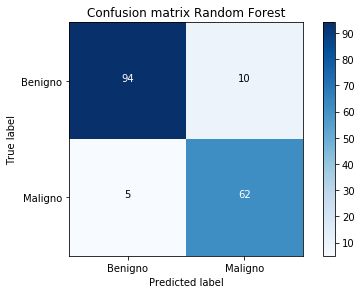

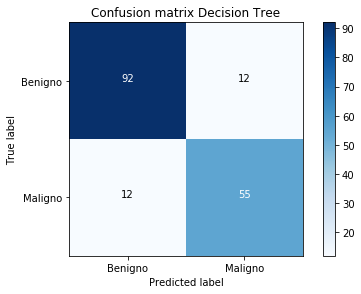

In [104]:
predicted_forest = model_forest.predict(testing[predictor_var_for].values)
predicted_tree = model_tree.predict(testing[predictor_var_tree].values)
true = testing[outcome_var]

# Compute confusion matrix
cnf_matrix_forest = metrics.confusion_matrix(true,predicted_forest)
cnf_matrix_tree = metrics.confusion_matrix(true,predicted_tree)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = ['Benigno', 'Maligno']
plt.figure()
plot_confusion_matrix(cnf_matrix_forest, classes=class_names, title='Confusion matrix Random Forest')
plt.figure()
plot_confusion_matrix(cnf_matrix_tree, classes=class_names, title='Confusion matrix Decision Tree')
plt.show()